In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Read data

In [2]:
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [3]:
locations = pd.read_csv("../assets/locations032017.csv", index_col=0)
locations.index = "V" + locations.index.astype(str)
locations.index.name = "device"
locations

,latitude,longitude
device,,
V1,1.306,103.920
V2,23.741,120.755
V3,25.073,121.536
V4,25.119,121.505
V5,25.056,121.552
...,...,...
V512,23.366,120.366
V513,22.954,120.244
V514,22.945,120.230


# 2. Model base + evaluation

In [30]:
df.iloc[:, 0].head(10)

time
1      8.234563
2      8.074951
3      7.918439
4      7.629787
5      7.533917
6      7.622310
7      8.015873
8      8.615079
9     12.857143
10     8.111111
Name: V1, dtype: float64

In [63]:
from sklearn.linear_model import RidgeCV
from abc import ABC, abstractmethod
from tqdm import tqdm

class Model(ABC):
    @abstractmethod
    def fit(self, data, horizon = 1):
        """
        Fits a h-step ahead model to the data.
        Forgets the previous fit if model was already fit.

        Parameters
        ----------
        data : pd.DataFrame
            The data to fit the model to.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        horizon : int
            The number of steps ahead to forecast.
        """
        ...

    @abstractmethod
    def predict(self, data):
        """
        Predicts X_{t+h} given X_t
        for each X_t (row) in the dataframe `data`.

        Parameters
        ----------
        data : pd.DataFrame
            The data to predict on.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        Returns
        -------
        pd.DataFrame
            The predicted values.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.
        """
        ...


class ARRidgeModel(Model):
    def fit(self, data, horizon = 1, lookback = 5):
        models = [RidgeCV() for _ in range(len(data.columns))]
        for col_index, model in enumerate(tqdm(models)):
            col = data.iloc[:, col_index]
            # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
            # y[t] = X[t + horizon] (horizon steps ahead)

            y = col[lookback + horizon - 1:]
            X = pd.concat([
                col.iloc[i: -lookback + i].reset_index(drop=True)
                for i in range(lookback)
            ], axis=1, keys=[f"lag_{lookback - i - 1}" for i in range(lookback)])
            X.index = data.index[lookback - 1:-horizon]
            y.index = X.index

            model.fit(X, y)


        self.models = models
        self.horizon = horizon
        self.lookback = lookback

    def predict(self, data):
        out = []
        for col_index, model in enumerate(self.models):
            col = data.iloc[:, col_index]
            X = pd.concat([
                col.iloc[i: -self.lookback + i].reset_index(drop=True)
                for i in range(self.lookback)
            ], axis=1, keys=[f"lag_{self.lookback - i - 1}" for i in range(self.lookback)])
            X.index = data.index[self.lookback - 1:-self.horizon]
            out.append(model.predict(X))
        return pd.DataFrame(np.array(out).T, index=data.index[self.lookback - 1:-self.horizon], columns=data.columns)

model = ARRidgeModel()
model.fit(df)

100%|██████████| 516/516 [00:00<00:00, 759.60it/s]


In [64]:
model.predict(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
5,9.643548,35.858027,36.499209,41.161178,42.623762,37.797757,38.217698,36.626812,37.165038,42.085216,...,49.336780,54.271976,47.033823,39.582780,34.984210,40.967416,48.950171,46.365011,47.170184,51.942071
6,9.732265,36.470871,36.142287,41.506138,42.321277,37.558999,37.938035,36.988748,37.356669,41.911499,...,48.863766,53.444952,47.760264,39.618078,34.870880,41.515591,49.817552,46.662881,47.902543,52.412753
7,10.119888,37.216527,35.890976,41.485990,41.869820,37.564474,38.131096,37.347152,37.676540,41.945295,...,48.369991,52.589440,48.170407,39.706783,34.947782,41.986729,50.456679,46.880351,48.390913,52.898986
8,10.642180,37.935998,35.953791,41.511261,41.899701,37.501823,38.405107,37.566453,37.791112,42.156889,...,48.046499,51.589104,49.047885,39.802183,35.072664,42.702263,51.335898,47.176368,49.122200,53.325045
9,15.027971,41.419501,29.234489,50.041229,35.525886,35.846557,46.279224,34.426722,31.800556,44.637465,...,53.238595,82.485596,41.579507,36.620484,26.352241,39.826532,45.071917,35.489168,40.847696,62.859409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,39.064957,12.635555,2.438970,6.013935,3.084051,5.817080,4.724197,2.931466,4.805642,4.785973,...,32.115874,34.830372,36.059827,33.724165,23.187787,32.855440,39.495430,32.954858,37.363078,38.865478
740,46.399730,13.334899,3.244400,6.974930,4.541598,5.269639,5.983692,2.935061,5.750915,4.190048,...,38.928188,44.444137,37.682067,26.765903,22.055504,37.045707,44.255805,34.761630,35.878036,36.802797
741,45.998018,19.709291,4.761223,8.876848,5.647300,6.691895,6.181899,4.587372,7.173867,5.574670,...,43.345228,42.387840,35.553225,20.300459,23.120347,32.542833,41.235813,34.419675,37.538373,39.971684


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_stats(test_data, fitted_model, horizon = 1, lookback = 5):
    yhat = model.predict(test_data)
    y = test_data.iloc[lookback + horizon - 1:]
    y.index = yhat.index

    y_flat = y.values.flatten()
    yhat_flat = yhat.values.flatten()

    return pd.Series({
        "mse": mean_squared_error(y_flat, yhat_flat),
        "mae": mean_absolute_error(y_flat, yhat_flat),
        "r2": r2_score(y_flat, yhat_flat)
    })

get_stats(df, model) # in-sample stats

mse    50.006663
mae     4.460032
r2      0.855275
dtype: float64

# 3. Crossval

<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

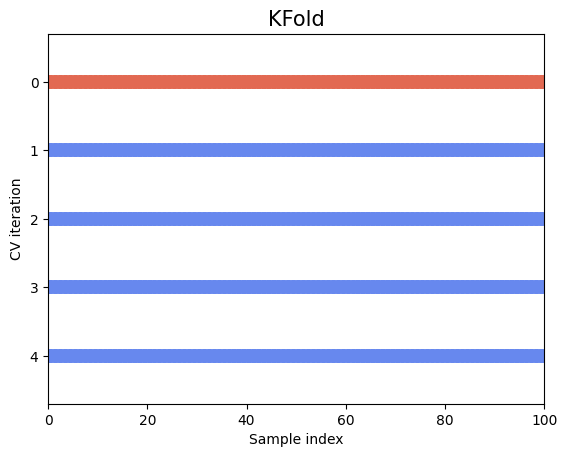

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, data, ax, n_splits, lw=10, lookback = 1, horizon = 1):
    """Create a sample plot for indices of a cross-validation object."""

    # Actual data column doesn't matter for CV visualization
    col = data.iloc[:, 0]
    # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
    # y[t] = X[t + horizon] (horizon steps ahead)

    y = col[lookback + horizon - 1:]
    X = pd.concat([
        col.iloc[i: -lookback + i].reset_index(drop=True)
        for i in range(lookback)
    ], axis=1, keys=[f"lag_{lookback - i - 1}" for i in range(lookback)])
    X.index = data.index[lookback - 1:-horizon]
    y.index = X.index

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

from sklearn.model_selection import KFold

fig, ax = plt.subplots()
n_splits = 5
cv = KFold(n_splits)
plot_cv_indices(cv, df, ax, n_splits)

In [ ]:
def crossval(data, model, horizon = 1, lookback = 5, n_splits = 5):
    stats = []
    for i in range(n_splits):
        train = data.iloc[:-(i + 1), :]
        test = data.iloc[-(i + 1):, :]
        model.fit(train, horizon = horizon, lookback = lookback)
        stats.append(get_stats(test, model, horizon = horizon, lookback = lookback))
    return pd.DataFrame(stats)